# Multivariate Linear Models

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
%matplotlib inline

In [3]:
sns.set()

## Spurious Association

### 5.1

In [4]:
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')
d["MedianAgeMarriage_s"] = (d["MedianAgeMarriage"] - d["MedianAgeMarriage"].mean())/d["MedianAgeMarriage"].std()

In [5]:
with pm.Model() as m5_1:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=10, sd=10)
    mu = pm.Deterministic("mu", a + bA * d["MedianAgeMarriage_s"])
    Divorce = pm.Normal("Divorce", mu=mu, sd=sigma, observed=d["Divorce"])
    trace_5_1 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1221.92draws/s]


### 5.2

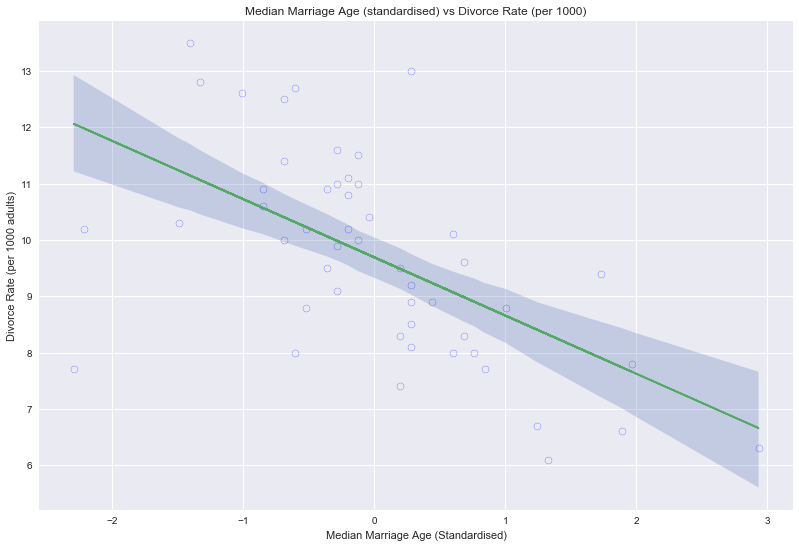

In [6]:
mu_mean = trace_5_1["mu"]
mu_pi = pm.hpd(mu_mean, alpha=0.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.plot(d["MedianAgeMarriage_s"], d["Divorce"], "o", mew=0.2, mec="b", mfc="None")
ax.plot(d["MedianAgeMarriage_s"], mu_mean.mean(0))

idx = np.argsort(d["MedianAgeMarriage_s"])
ax.fill_between(d["MedianAgeMarriage_s"][idx], mu_pi[:,0][idx], mu_pi[:,1][idx], alpha=0.25)

ax.set_title("Median Marriage Age (standardised) vs Divorce Rate (per 1000)")
ax.set_xlabel("Median Marriage Age (Standardised)")
ax.set_ylabel("Divorce Rate (per 1000 adults)");

### 5.3

In [7]:
d["Marriage_s"] = (d["Marriage"] - d["Marriage"].mean())/d["Marriage"].std()

In [8]:
with pm.Model() as m5_2:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=10, sd=10)
    mu = pm.Deterministic("mu", a + bA * d["Marriage_s"])
    Divorce = pm.Normal("Divorce", mu=mu, sd=sigma, observed=d["Divorce"])
    trace_5_2 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1286.61draws/s]


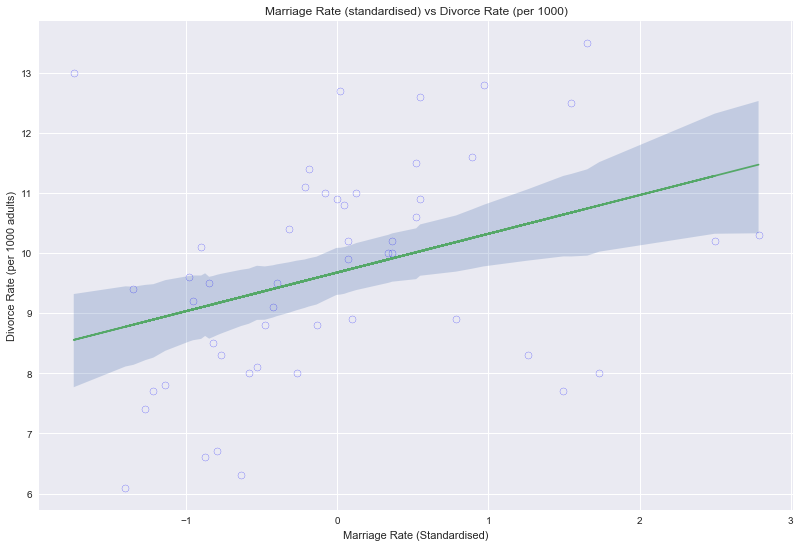

In [9]:
mu_mean = trace_5_2["mu"]
mu_pi = pm.hpd(mu_mean, alpha=0.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.plot(d["Marriage_s"], d["Divorce"], "o", mew=0.2, mec="b", mfc="None")
ax.plot(d["Marriage_s"], mu_mean.mean(0))

idx = np.argsort(d["Marriage_s"])
ax.fill_between(d["Marriage_s"][idx], mu_pi[:,0][idx], mu_pi[:,1][idx], alpha=0.25)

ax.set_title("Marriage Rate (standardised) vs Divorce Rate (per 1000)")
ax.set_xlabel("Marriage Rate (Standardised)")
ax.set_ylabel("Divorce Rate (per 1000 adults)");

### 5.4

In [10]:
with pm.Model() as m5_3:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bA = pm.Normal("bA", mu=0, sd=1)    
    bR = pm.Normal("bR", mu=0, sd=1)    
    a = pm.Normal("a", mu=10, sd=10)
    mu = pm.Deterministic("mu", a + bR * d["Marriage_s"] + bA * d["MedianAgeMarriage_s"])
    Divorce = pm.Normal("Divorce", mu=mu, sd=sigma, observed=d["Divorce"])
    trace_5_3 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 775.70draws/s] 


In [11]:
pm.summary(trace_5_3, varnames=["a", "bR", "bA", "sigma"], alpha=0.11)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,9.693860,0.220871,0.005572,9.324993,10.025225,1892.599500,0.999511
bR,-0.113223,0.308901,0.007250,-0.577719,0.400093,1356.552865,1.000108
bA,-1.110755,0.308062,0.007900,-1.634040,-0.640148,1293.705513,1.000104
sigma,1.527301,0.166804,0.003895,1.265117,1.764816,1716.230082,0.999838


### 5.5

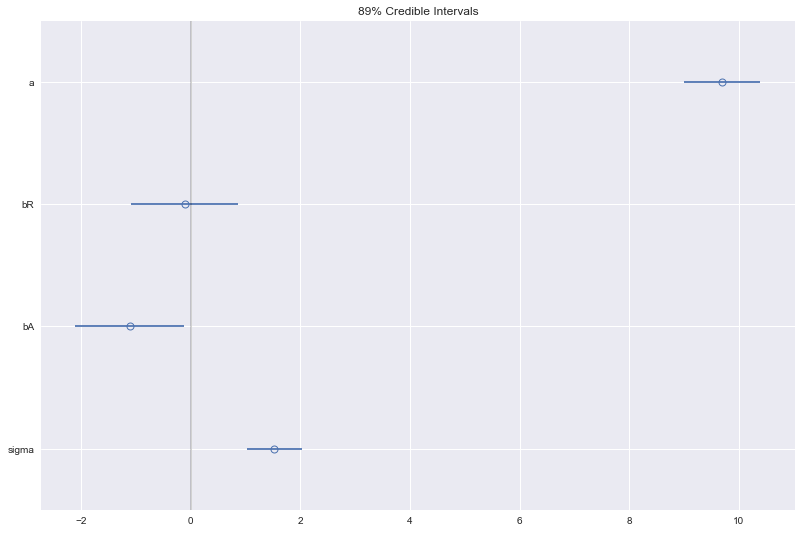

In [12]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
data = pm.summary(trace_5_3, varnames=["a", "bR", "bA", "sigma"], alpha=0.11)
ax.errorbar(data["mean"], data.index, fmt="o", xerr=data["hpd_94.5"] - data["hpd_5.5"], 
            mew=1, mfc="None")
ax.vlines(0, ymin=-1, ymax=4, alpha=0.2);
ax.set_ylim(-0.5, 3.5)
ax.invert_yaxis()
ax.set_title("89% Credible Intervals");

### 5.6

In [13]:
with pm.Model() as m5_4:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    b = pm.Normal("b", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=10)
    mu = pm.Deterministic("mu", a + b * d["MedianAgeMarriage_s"])
    Marriage_s = pm.Normal("Marriage_s", mu=mu, sd=sigma, observed=d["Marriage_s"])
    trace_5_4 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:12<00:00, 328.44draws/s]


### 5.7

In [14]:
mu = trace_5_4["mu"].mean(0)
m_resid = d["Marriage_s"] - mu

### 5.8

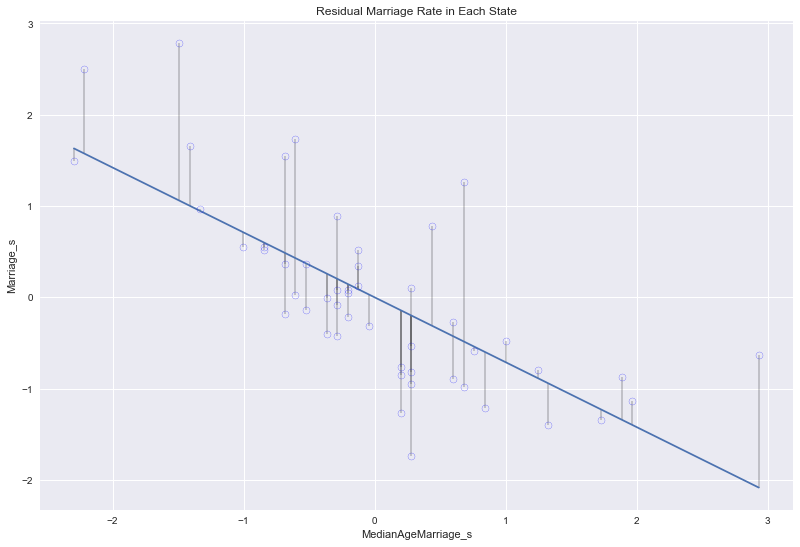

In [15]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
idx = np.argsort(d["MedianAgeMarriage_s"])
ax.plot(d["MedianAgeMarriage_s"][idx], mu[idx])
ax.vlines(d["MedianAgeMarriage_s"], mu, mu + m_resid, alpha=0.2)
ax.plot(d["MedianAgeMarriage_s"], mu + m_resid, "o", mew=0.2, mec="b", mfc="None")
ax.set_title("Residual Marriage Rate in Each State")
ax.set_xlabel("MedianAgeMarriage_s")
ax.set_ylabel("Marriage_s");

### 5.9

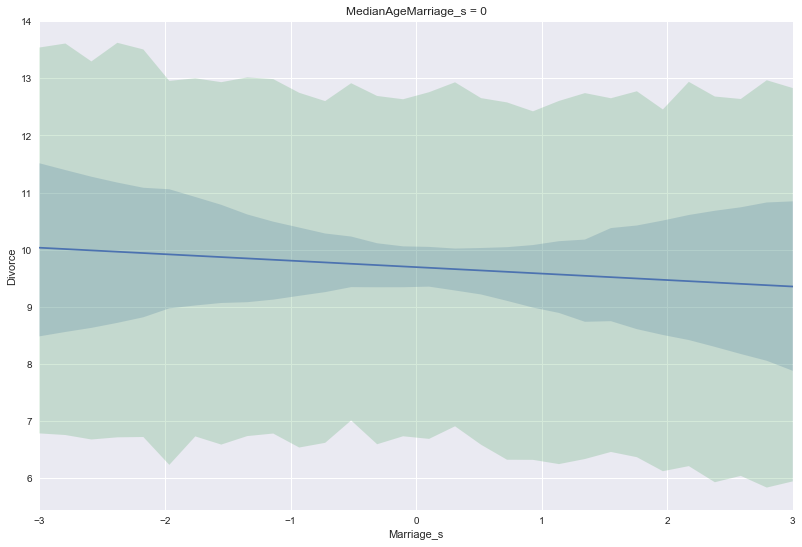

In [16]:
A_avg = d["MedianAgeMarriage_s"].mean()
R_seq = np.linspace(-3, 3, 30)

mu = trace_5_3["a"].reshape(-1, 1) +\
     (trace_5_3["bA"] * A_avg).reshape(-1, 1) +\
     (trace_5_3["bR"].reshape(-1, 1) * R_seq)

sigma = (trace_5_3["sigma"]
         .repeat(30)
         .reshape(-1, 30))

R_sim = stats.norm.rvs(loc=mu, scale=sigma)
mu_mean = mu.mean(axis=0)
mu_pi = pm.hpd(mu, alpha=.11)
R_pi = pm.hpd(R_sim)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(R_seq, mu_mean)
ax.fill_between(R_seq, mu_pi[:,0], mu_pi[:,1], alpha=0.25)
ax.fill_between(R_seq, R_pi[:,0], R_pi[:,1], alpha=0.25)
ax.set_title("MedianAgeMarriage_s = 0")
ax.set_xlabel("Marriage_s")
ax.set_ylabel("Divorce")
ax.set_xlim(-3, 3);

### 5.10

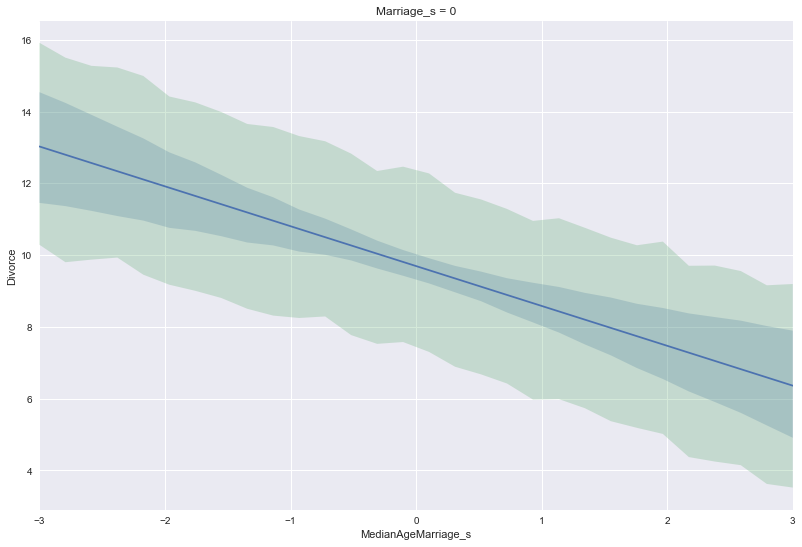

In [17]:
A_seq = np.linspace(-3, 3, 30)
R_avg = d["Marriage_s"].mean()

mu = trace_5_3["a"].reshape(-1, 1) +\
     (trace_5_3["bA"].reshape(-1, 1) * A_seq) +\
     (trace_5_3["bR"] * R_avg).reshape(-1, 1)

sigma = (trace_5_3["sigma"]
         .repeat(30)
         .reshape(-1, 30))

A_sim = stats.norm.rvs(loc=mu, scale=sigma)
mu_mean = mu.mean(axis=0)
mu_pi = pm.hpd(mu, alpha=.11)
A_pi = pm.hpd(A_sim, alpha=.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(A_seq, mu_mean)
ax.fill_between(A_seq, mu_pi[:,0], mu_pi[:,1], alpha=0.25)
ax.fill_between(A_seq, A_pi[:,0], A_pi[:,1], alpha=0.25)
ax.set_title("Marriage_s = 0")
ax.set_xlabel("MedianAgeMarriage_s")
ax.set_ylabel("Divorce")
ax.set_xlim(-3, 3);

### 5.11

In [18]:
mu = trace_5_3["mu"]

mu_mean = mu.mean(0).reshape(-1, 1)
mu_pi = pm.hpd(mu, alpha=.11)

divorce_sim = pm.sample_ppc(trace_5_3, samples=1000, model=m5_3)['Divorce']
divorce_mean = divorce_sim.mean(0).reshape(-1, 1)
divorce_pi = pm.hpd(divorce_sim, alpha=.11)

100%|██████████| 1000/1000 [00:03<00:00, 323.77it/s]


### 5.12 - 5.13

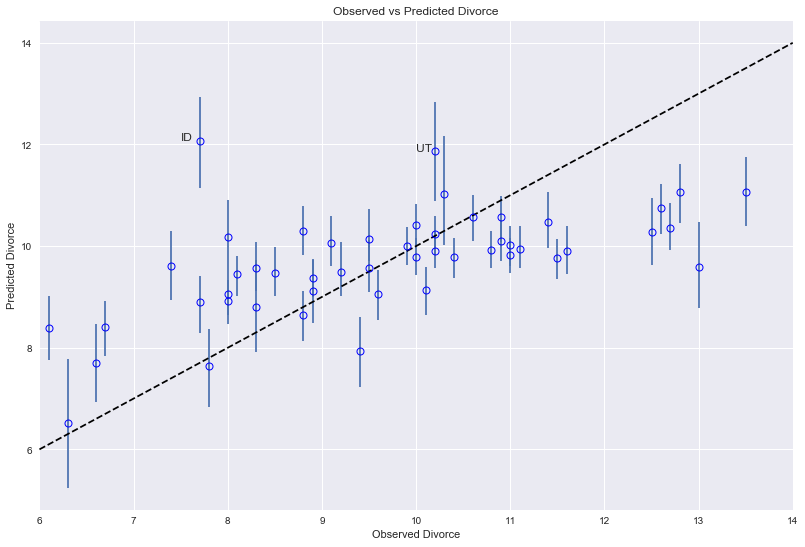

In [19]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.errorbar(x=d["Divorce"], y=mu_mean, fmt="o", yerr=np.abs(mu_mean - mu_pi).T,
           mew=1.0, mec="b", mfc="None");
ax.plot([6, 14], [6, 14], "k--")
ax.set_title("Observed vs Predicted Divorce")
ax.set_xlabel("Observed Divorce")
ax.set_ylabel("Predicted Divorce")
ax.set_xlim(6, 14)

ID = (d.loc[12]["Divorce"], mu_mean[12])
UT = (d.loc[43]["Divorce"], mu_mean[43])
ax.annotate("ID", ID, xytext=(ID[0]-0.2, ID[1]))
ax.annotate("UT", UT, xytext=(UT[0]-0.2, UT[1]));

### 5.14

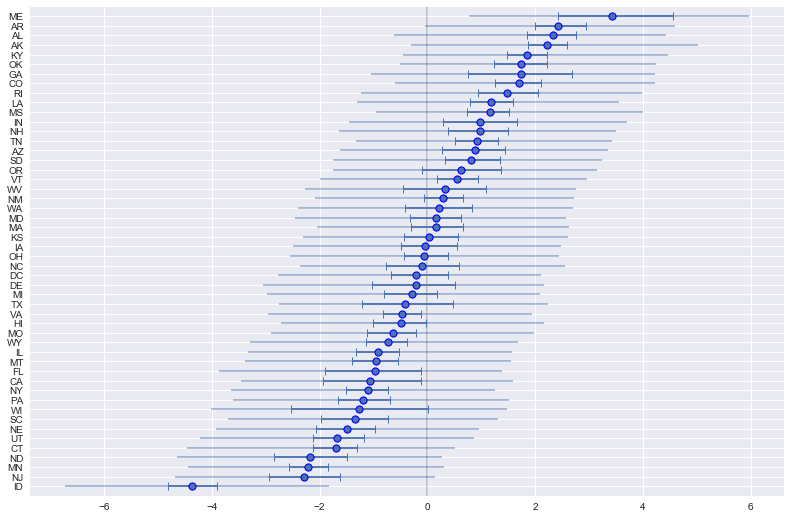

In [20]:
divorce_resid = d["Divorce"] - mu_mean.ravel()
o = np.argsort(divorce_resid)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.vlines(0, -1, len(d), alpha=0.2)
ax.errorbar(divorce_resid[o], d.loc[o]["Loc"], xerr=np.abs(mu_mean-divorce_pi).T,
            fmt="o", mfc="C0", mew=1.0, mec="b", alpha=0.5, ecolor="C0")    
ax.errorbar(divorce_resid[o], d.loc[o]["Loc"], xerr=np.abs(mu_mean-mu_pi).T, 
            fmt="o", capsize=4, mfc="C0", mew=1.0, mec="b", ecolor="C0")
ax.set_ylim(-1, len(d));

### 5.15

In [21]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(loc=x_real)
y = stats.norm.rvs(size=N, loc=x_real)
d = pd.DataFrame({"y": y,
                  "x_real": x_real,
                  "x_spur": x_spur})

## Masked Relationship

### 5.16

In [22]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


### 5.17

In [23]:
with pm.Model() as m5_5:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    bn = pm.Normal("bn", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bn * d["neocortex.perc"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_5 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bn, sigma]
Sampling 2 chains:   0%|          | 0/4000 [00:00<?, ?draws/s]


RuntimeError: Chain 1 failed.

### 5.18

In [24]:
d["neocortex.perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

### 5.19

In [25]:
dcc = d.dropna()

### 5.20

In [26]:
with pm.Model() as m5_5:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    bn = pm.Normal("bn", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bn * dcc["neocortex.perc"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=dcc["kcal.per.g"])
    trace_5_5 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bn, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:21<00:00, 183.56draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


### 5.21

In [27]:
pm.summary(trace_5_5, varnames=["a", "bn", "sigma"], alpha=0.11).round(3)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.340,0.540,0.019,-0.443,1.171,718.205,1.001
bn,0.005,0.008,0.000,-0.008,0.016,718.050,1.002
sigma,0.192,0.040,0.002,0.131,0.246,477.044,1.000


### 5.22

In [28]:
trace_5_5["bn"].mean() * (76 - 55)

0.0988342145124094

### 5.23

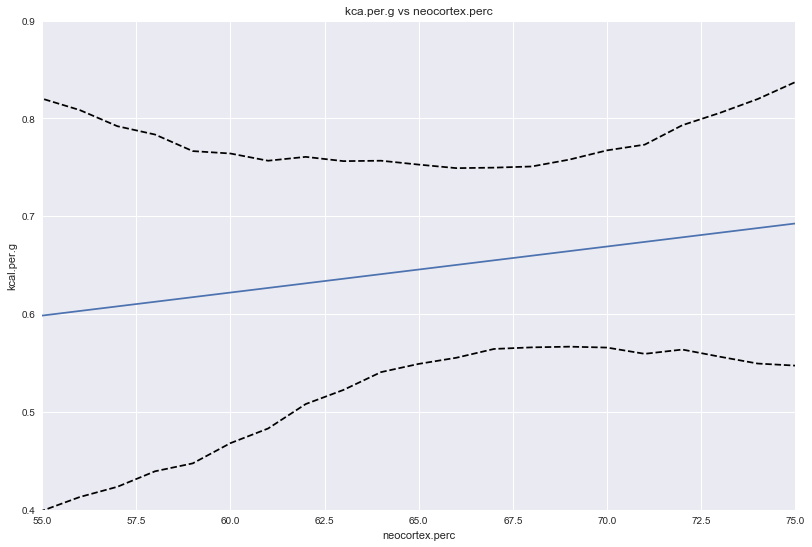

In [29]:
np_seq = np.arange(0, 100)

mu = trace_5_5["a"].reshape(-1, 1) +\
     (trace_5_5["bn"].reshape(-1, 1) * np_seq)

mu_mean = mu.mean(0)
mu_pi = pm.hpd(mu)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(np_seq, mu_mean)
ax.plot(np_seq, mu_pi[:, 0], "k--")
ax.plot(np_seq, mu_pi[:, 1], "k--")
ax.set_xlabel("neocortex.perc")
ax.set_ylabel("kcal.per.g")
ax.set_xlim(55, 75)
ax.set_title("kca.per.g vs neocortex.perc")
ax.set_ylim(0.4, 0.9);

### 5.24

In [30]:
dcc["log_mass"] = np.log(dcc["mass"])

### 5.25

In [31]:
with pm.Model() as m5_6:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    bm = pm.Normal("bm", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bm * dcc["log_mass"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=dcc["kcal.per.g"])
    trace_5_6 = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_5_6, varnames=["a", "bm", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bm, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1234.67draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.706620,0.058597,0.002075,0.613201,0.80066,758.484968,1.000018
bm,-0.032081,0.024076,0.000887,-0.069177,0.00591,783.486897,1.001055
sigma,0.183283,0.037797,0.001197,0.122840,0.23801,1011.591419,1.004936


### 5.26

In [32]:
with pm.Model() as m5_7:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    bm = pm.Normal("bm", mu=0, sd=1)    
    bn = pm.Normal("bn", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bm*dcc["log_mass"] + bn*dcc["neocortex.perc"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=dcc["kcal.per.g"])
    trace_5_7 = pm.sample(draws=1000, tune=1000)

pm.summary(trace_5_7, varnames=["a", "bm", "bn", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bn, bm, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:33<00:00, 121.19draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-1.094748,0.598340,0.026406,-2.061748,-0.146839,422.511360,1.000310
bm,-0.095546,0.028588,0.001181,-0.142584,-0.052625,464.958775,1.000648
bn,0.028051,0.009290,0.000414,0.011650,0.041460,411.610349,1.000314
sigma,0.138764,0.030925,0.001374,0.085435,0.177094,381.757660,1.001119


### 5.27

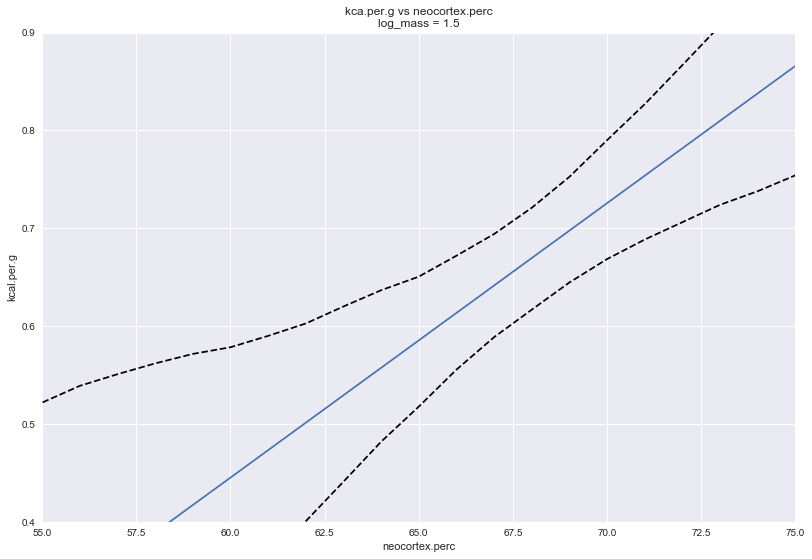

In [33]:
mean_log_mass = dcc["log_mass"].mean()
np_seq = np.arange(0, 100)

mu = trace_5_7["a"].reshape(-1, 1) +\
     (trace_5_7["bm"] * mean_log_mass).reshape(-1, 1) +\
     (trace_5_7["bn"].reshape(-1, 1) * np_seq)

mu_mean = mu.mean(axis=0)
mu_pi = pm.hpd(mu, alpha=.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(np_seq, mu_mean)
ax.plot(np_seq, mu_pi[:, 0], "k--")
ax.plot(np_seq, mu_pi[:, 1], "k--")
ax.set_xlabel("neocortex.perc")
ax.set_ylabel("kcal.per.g")
ax.set_xlim(55, 75)
ax.set_title("kca.per.g vs neocortex.perc\nlog_mass = 1.5")
ax.set_ylim(0.4, 0.9);

### 5.28

In [34]:
N = 100
rho = 0.7
x_pos = stats.norm.rvs(size=N)
x_neg = stats.norm.rvs(loc=rho*x_pos, scale=np.sqrt(1-rho**2))
y = stats.norm.rvs(loc=x_pos-x_neg)
d = pd.DataFrame({"y": y,
                  "x_pos": x_pos,
                  "x_neg": x_neg})

## When adding variables hurts

### 5.29

In [35]:
N = 100
height = stats.norm.rvs(10, 2, N)
leg_prop = stats.uniform.rvs(0.4, 0.5, N)
leg_left = leg_prop*height + stats.norm.rvs(0, 0.02, N)
leg_right = leg_prop*height + stats.norm.rvs(0, 0.02, N)
d = pd.DataFrame({"height": height,
                  "leg_left": leg_left,
                  "leg_right": leg_right})

### 5.30

In [36]:
with pm.Model() as m5_8:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    br = pm.Normal("br", mu=2, sd=10)
    bl = pm.Normal("bl", mu=2, sd=10)
    a = pm.Normal("a", mu=10, sd=100)
    mu = pm.Deterministic("mu", a + bl*d["leg_left"] + br*d["leg_right"])
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d["height"])
    trace_5_8 = pm.sample(draws=1000, tune=1000)

pm.summary(trace_5_8, varnames=["a", "bl", "br", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bl, br, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [03:11<00:00, 10.42draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,6.024108,0.469483,0.014056,5.277094,6.760257,1144.891033,0.999994
bl,2.051456,4.000520,0.125248,-4.210770,8.441851,996.018593,1.000650
br,-1.454462,3.992275,0.124788,-7.877597,4.741355,996.793710,1.000670
sigma,1.359189,0.100528,0.003004,1.199283,1.512479,1019.302350,0.999893


### 5.31

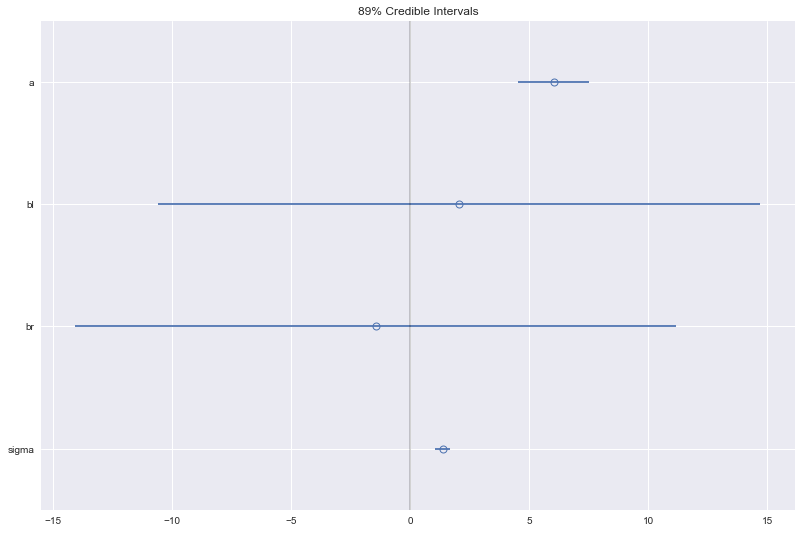

In [37]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
data = pm.summary(trace_5_8, varnames=["a", "bl", "br", "sigma"], alpha=0.11)
ax.errorbar(data["mean"], data.index, fmt="o", xerr=data["hpd_94.5"] - data["hpd_5.5"], 
            mew=1, mfc="None")
ax.vlines(0, ymin=-1, ymax=4, alpha=0.2);
ax.set_ylim(-0.5, 3.5)
ax.invert_yaxis()
ax.set_title("89% Credible Intervals");

### 5.32

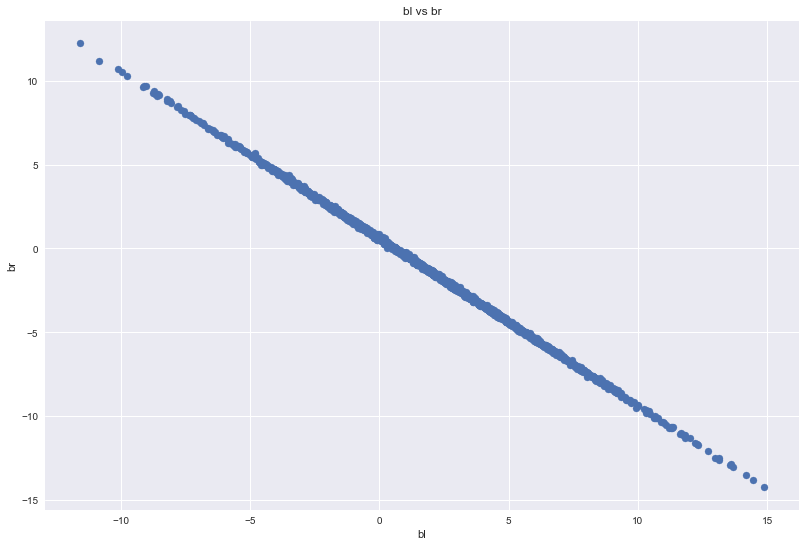

In [38]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.scatter(trace_5_8["bl"], trace_5_8["br"])
ax.set_xlabel("bl")
ax.set_ylabel("br")
ax.set_title("bl vs br");

### 5.33

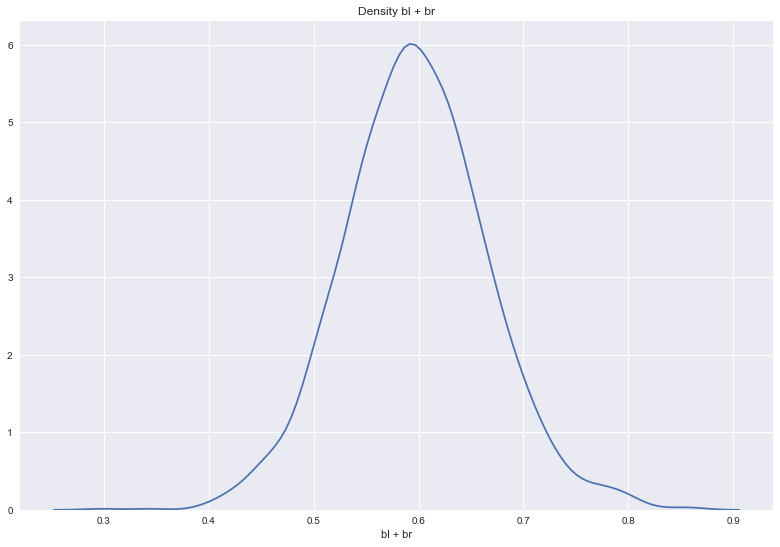

In [39]:
sum_blbr = trace_5_8["bl"] + trace_5_8["br"]

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
sns.kdeplot(sum_blbr, ax=ax)
ax.set_title("Density bl + br")
ax.set_xlabel("bl + br");

### 5.34

In [40]:
with pm.Model() as m5_9:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bl = pm.Normal("bl", mu=2, sd=10)
    a = pm.Normal("a", mu=10, sd=100)
    mu = pm.Deterministic("mu", a + bl*d["leg_left"])
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d["height"])
    trace_5_9 = pm.sample(draws=1000, tune=1000)

pm.summary(trace_5_9, varnames=["a", "bl", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bl, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 845.31draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,6.088149,0.440356,0.016465,5.404007,6.766431,795.281923,0.999541
bl,0.587103,0.064361,0.002371,0.489893,0.688843,846.762151,0.999554
sigma,1.350613,0.102918,0.003257,1.191191,1.515729,878.797636,0.999615


### 5.35

In [41]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


### 5.36

In [42]:
# kcal.per.g regressed on perc.fat
with pm.Model() as m5_10:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bf = pm.Normal("bf", mu=0, sd=1)
    a = pm.Normal("a", mu=0.6, sd=10)
    mu = pm.Deterministic("mu", a + bf*d["perc.fat"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_10 = pm.sample(draws=1000, tune=1000)

# kcal.per.g regressed on perc.lactose
with pm.Model() as m5_11:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bl = pm.Normal("bl", mu=0, sd=1)
    a = pm.Normal("a", mu=0.6, sd=10)
    mu = pm.Deterministic("mu", a + bl*d["perc.lactose"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_11 = pm.sample(draws=1000, tune=1000)
    
print(pm.summary(trace_5_10, varnames=["a", "bf", "sigma"], alpha=0.11).round(3))
print(pm.summary(trace_5_11, varnames=["a", "bl", "sigma"], alpha=0.11).round(3))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bf, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:10<00:00, 381.77draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bl, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:11<00:00, 339.95draws/s]

        mean     sd  mc_error  hpd_5.5  hpd_94.5    n_eff   Rhat
a      0.301  0.039     0.001    0.235     0.360  556.096  1.001
bf     0.010  0.001     0.000    0.008     0.012  571.106  1.001
sigma  0.080  0.012     0.000    0.060     0.096  866.653  1.001
        mean     sd  mc_error  hpd_5.5  hpd_94.5    n_eff   Rhat
a      1.167  0.047     0.002    1.094     1.240  626.162  1.001
bl    -0.011  0.001     0.000   -0.012    -0.009  622.893  1.001
sigma  0.067  0.010     0.000    0.051     0.080  629.752  1.002


### 5.37

In [43]:
with pm.Model() as m5_12:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bl = pm.Normal("bl", mu=0, sd=1)
    bf = pm.Normal("bf", mu=0, sd=1)
    a = pm.Normal("a", mu=0.6, sd=10)
    mu = pm.Deterministic("mu", a + bf*d["perc.fat"] + bl*d["perc.lactose"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_12 = pm.sample(draws=1000, tune=1000)

pm.summary(trace_5_12, varnames=["a", "bf", "bl", "sigma"], alpha=0.11).round(3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bf, bl, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:16<00:00, 248.50draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,1.005,0.216,0.009,0.698,1.392,530.066,1.0
bf,0.002,0.003,0.000,-0.003,0.006,524.793,1.0
bl,-0.009,0.003,0.000,-0.013,-0.005,544.587,1.0
sigma,0.068,0.009,0.000,0.054,0.081,821.923,1.0


### 5.38

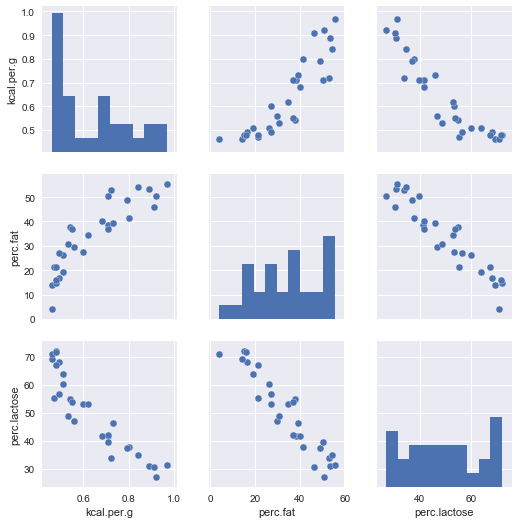

In [44]:
data = d[["kcal.per.g", "perc.fat", "perc.lactose"]]
sns.pairplot(data);

### 5.39

In [45]:
d.corr()["perc.fat"]["perc.lactose"]

-0.9416373456839282

### 5.40

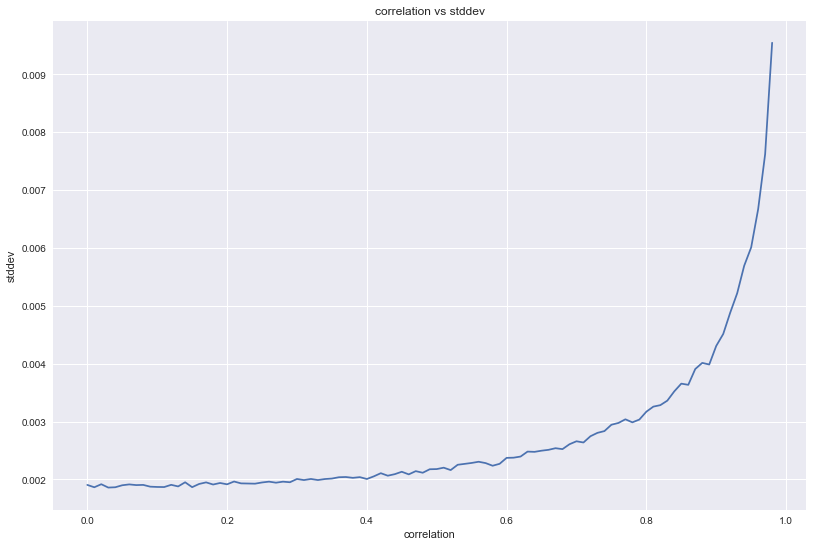

In [46]:
d = pd.read_csv('Data/milk.csv', sep=';')

def sim_coll(r=0.9):
    d['x'] = stats.norm.rvs(size=len(d), 
                            loc = r * d['perc.fat'],
                            scale = np.sqrt((1 - r**2) * d['perc.fat'].var()))
    m = smf.OLS(d['kcal.per.g'], d[["perc.fat", "x"]]).fit()
    cov = m.cov_params()
    return (np.diag(cov)[1])**0.5
    
def rep_sim_coll(r=0.9, n=100):
    stddev = [sim_coll(r) for _ in range(n)]
    return np.mean(stddev)

r_seq = np.arange(0, 0.99, 0.01)
stddev = [rep_sim_coll(r=z, n=100) for z in r_seq]


f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(r_seq, stddev)
ax.set_title("correlation vs stddev")
ax.set_xlabel("correlation")
ax.set_ylabel("stddev");

### 5.41

In [47]:
# Number of Plants
N = 100

# simulate initial heights
h0 = stats.norm.rvs(10, 2, N)

# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], [N/2]*2)
fungus = stats.binom.rvs(1, 0.5 - treatment*0.4)
h1 = h0 + stats.norm.rvs(5-3*fungus)

# compose a clean data frame
d = pd.DataFrame({"h0": h0,
                  "h1": h1,
                  "treatment": treatment,
                  "fungus": fungus})

### 5.42

In [48]:
with pm.Model() as m5_13:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bf = pm.Normal("bf", mu=0, sd=10)
    bt = pm.Normal("bt", mu=0, sd=10)
    bh = pm.Normal("bh", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bh*d["h0"] + bt*d["treatment"] + bf*d["fungus"])
    h1 = pm.Normal("h1", mu=mu, sd=sigma, observed=d["h1"])
    trace_5_13 = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_5_13, varnames=["a", "bh", "bt", "bf", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bh, bt, bf, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:16<00:00, 236.61draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,5.296554,0.589143,0.018143,4.418753,6.298802,929.623657,1.000209
bh,0.963320,0.055639,0.001698,0.869640,1.049222,971.523864,0.999750
bt,-0.002786,0.249056,0.005744,-0.424126,0.363138,1537.563434,0.999501
bf,-3.390140,0.265450,0.006424,-3.835326,-2.994846,1650.948148,0.999758
sigma,1.099604,0.079337,0.002035,0.964792,1.213882,1429.285244,0.999577


### 5.43

In [49]:
with pm.Model() as m5_14:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bt = pm.Normal("bt", mu=0, sd=10)
    bh = pm.Normal("bh", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bh*d["h0"] + bt*d["treatment"])
    h1 = pm.Normal("h1", mu=mu, sd=sigma, observed=d["h1"])
    trace_5_14 = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_5_14, varnames=["a", "bh", "bt", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bh, bt, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:12<00:00, 312.20draws/s]
The acceptance probability does not match the target. It is 0.8945149583251492, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,3.348622,0.960578,0.035145,1.848130,4.858385,622.884130,0.999808
bh,0.982672,0.093589,0.003492,0.829057,1.128671,594.630462,1.000053
bt,1.343651,0.364687,0.009119,0.788448,1.956784,1183.215246,1.000644
sigma,1.836555,0.135702,0.003405,1.606222,2.030844,1256.211493,0.999723


## Categorical Variables

### 5.44

In [50]:
d = pd.read_csv('Data/Howell1.csv', sep=';')
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


### 5.45

In [51]:
with pm.Model() as m5_15:
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    bm = pm.Normal("bm", mu=0, sd=10)
    a = pm.Normal("a", mu=178, sd=100)
    mu = pm.Deterministic("mu", a + bm*d["male"])
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d["height"])
    trace_5_15 = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_5_15, varnames=["a", "bm", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bm, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 839.78draws/s] 


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,134.755376,1.560939,0.049997,132.237244,137.183963,866.918638,1.012756
bm,7.396109,2.260458,0.067214,3.644011,10.839791,1005.948485,1.011410
sigma,27.433581,0.850043,0.019469,26.133510,28.828995,1752.093309,1.001003


### 5.46

In [52]:
mu_male = trace_5_15["a"] + trace_5_15["bm"]
pm.hpd(mu_male, alpha=0.11)

array([139.482628  , 144.96219743])

### 5.47

In [53]:
with pm.Model() as m5_15b:
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    am = pm.Normal("am", mu=178, sd=100)
    af = pm.Normal("af", mu=178, sd=100)
    mu = pm.Deterministic("mu", af*(1-d["male"]) + am*d["male"])
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d["height"])
    trace_5_15b = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [af, am, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1049.18draws/s]


### 5.48

In [54]:
d = pd.read_csv('Data/milk.csv', sep=';')
d["clade"].drop_duplicates()

0        Strepsirrhine
5     New World Monkey
14    Old World Monkey
20                 Ape
Name: clade, dtype: object

### 5.49

In [55]:
d["clade_NWM"] = np.where(d["clade"] == "New World Monkey", 1, 0)

### 5.50

In [56]:
d["clade_OWM"] = np.where(d["clade"] == "Old World Monkey", 1, 0)
d["clade_S"] = np.where(d["clade"] == "Strepsirrhine", 1, 0)

### 5.51

In [57]:
with pm.Model() as m5_16:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    b_S = pm.Normal("b_S", mu=0, sd=1)
    b_OWM = pm.Normal("b_OWM", mu=0, sd=1)
    b_NWM = pm.Normal("b_NWM", mu=0, sd=1)
    a = pm.Normal("a", mu=0.6, sd=10)
    mu = pm.Deterministic("mu", a + b_NWM*d["clade_NWM"] + b_OWM*d["clade_OWM"] + b_S*d["clade_S"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_16 = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_5_16, varnames=["a", "b_NWM", "b_OWM", "b_S", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b_NWM, b_OWM, b_S, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 632.93draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.543801,0.044694,0.001360,0.480002,0.618558,1059.197166,0.999863
b_NWM,0.170834,0.062034,0.001792,0.080751,0.278093,1178.869590,0.999782
b_OWM,0.244579,0.070477,0.001895,0.136079,0.362811,1196.493355,0.999891
b_S,-0.034453,0.074504,0.001928,-0.146935,0.087991,1309.791674,0.999726
sigma,0.130243,0.019010,0.000555,0.103183,0.160920,1215.991029,0.999503


### 5.52

In [58]:
mu_ape = trace_5_16["a"]
mu_NWM = trace_5_16["a"] + trace_5_16["b_NWM"]
mu_OWM = trace_5_16["a"] + trace_5_16["b_OWM"]
mu_S = trace_5_16["a"] + trace_5_16["b_S"]

mu = np.stack([mu_ape, mu_NWM, mu_OWM, mu_S]).T
mu_mean = np.mean(mu, axis=0)
mu_std = np.std(mu, axis=0)
mu_hpd = pm.hpd(mu, alpha=0.11)

pd.DataFrame({"mean": mu_mean,
              "std": mu_std,
              "hpd_5.5": mu_hpd[:, 0],
              "hpd_94.5": mu_hpd[:, 1]},
             index=["mu_ape", "mu_NWM", "mu_OWM", "mu_S"])

,mean,std,hpd_5.5,hpd_94.5
mu_ape,0.543801,0.044694,0.480002,0.618558
mu_NWM,0.714635,0.044166,0.642832,0.783557
mu_OWM,0.788380,0.053350,0.702127,0.873005
mu_S,0.509349,0.059538,0.415468,0.602729


### 5.53

In [59]:
diff_NWM_OWM = mu_NWM - mu_OWM
np.percentile(diff_NWM_OWM, [2.5, 50, 97.5])

array([-0.2107932, -0.0737091,  0.0655952])

### 5.54

In [60]:
d["clade_id"] = pd.Categorical(d["clade"]).codes

### 5.55

In [61]:
with pm.Model() as m5_16_alt:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    a = pm.Normal("a", mu=0.6, sd=10, shape=len(d["clade_id"].unique()))
    kcal_per_g = pm.Normal("kcal_per_g", mu=a[d["clade_id"].values], sd=sigma, observed=d["kcal.per.g"])
    trace_5_16_alt = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_5_16_alt, varnames=["a", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 960.89draws/s] 


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a__0,0.544796,0.044276,0.000938,0.478030,0.618972,2227.560916,1.000613
a__1,0.714585,0.042784,0.000937,0.646750,0.785691,1950.314858,1.002285
a__2,0.790123,0.052448,0.001094,0.715367,0.883446,2417.161416,0.999533
a__3,0.508480,0.059750,0.001369,0.418660,0.608811,1983.905880,0.999608
sigma,0.130201,0.019785,0.000527,0.096867,0.157066,1375.862152,0.999775


### Ordinary Least Squares and `lm`

Code blocks *5.56 - 6.61* are specific to R's `lm` function and aren't that useful in this exercise

### 5.62

In [62]:
cars = pd.read_csv('Data/cars.csv', index_col=0)
pm.GLM.from_formula("dist ~ speed", data=cars)

## Practice

### Easy

#### 5E1.

2. $\mu_i = \alpha + \beta x_i$
4. $\mu_i = \alpha + \beta_x x_i + \beta_z z_i$

#### 5E2.

$a_i = \alpha + \beta_l l_i + \beta_p p_i$

#### 5E3.

$t_i = \alpha + \beta_f f_i + \beta_s s_i$

Since `Time to PHD` is positively associated with both variables, both $\beta_f$ and $\beta_s$ should have positive slopes

#### 5E4.

(1), (3) and (5) are inferentially equivalent

### Medium

#### 5M1.

In [63]:
x1 = stats.norm.rvs(0, 10, 100)
x2 = stats.norm.rvs(x1, 1, 100)
y = stats.norm.rvs(x1, 1, 100)

with pm.Model() as m_5m1:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    a = pm.Normal("a", mu=0, sd=1)
    b_x1 = pm.Normal("b_x1", mu=0, sd=1)
    b_x2 = pm.Normal("b_x2", mu=0, sd=1)
    mu = pm.Deterministic("mu", a + b_x1*x1 + b_x2*x2)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=y)
    trace_5m1 = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_5m1, varnames=["a", "b_x1", "b_x2", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_x2, b_x1, a, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:13<00:00, 287.48draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,-0.136128,0.099062,0.002776,-0.330632,0.058866,1326.505990,1.000980
b_x1,0.971546,0.095843,0.002919,0.781287,1.150636,875.031257,1.000771
b_x2,0.011162,0.095004,0.002891,-0.170680,0.192958,865.700429,1.000954
sigma,0.962507,0.030045,0.000777,0.902814,0.999995,1457.616534,1.000387


#### 5M2.

In [64]:
x1 = stats.norm.rvs(0, 10, 100)
x2 = stats.norm.rvs(x1, 1, 100)
y = stats.norm.rvs(x1-x2, 1, 100)


with pm.Model() as m_5m2:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    a = pm.Normal("a", mu=0, sd=1)
    b_x1 = pm.Normal("b_x1", mu=0, sd=1)
    b_x2 = pm.Normal("b_x2", mu=0, sd=1)
    mu = pm.Deterministic("mu", a + b_x1*x1 + b_x2*x2)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=y)
    trace_5m2 = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_5m2, varnames=["a", "b_x1", "b_x2", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_x2, b_x1, a, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:18<00:00, 219.02draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,-0.017183,0.102202,0.002965,-0.217118,0.182951,957.953146,0.999659
b_x1,0.900912,0.088339,0.002750,0.729954,1.077785,888.456628,0.999896
b_x2,-0.916551,0.087759,0.002747,-1.107855,-0.757519,887.665660,0.999869
sigma,0.952068,0.034971,0.000838,0.883243,0.999957,1575.952728,0.999788


#### 5M3.

If marriage rate is defined to be the share of the population that has ever been married, then a high divorce rate might _cause_ a high marriage rate by increasing the number of re-marriages that happen between divorcees and non divorcees.

#### 5M4.

In [65]:
divorce = pd.read_csv('Data/WaffleDivorce.csv', sep=';')

In [66]:
# https://www.worldatlas.com/articles/mormon-population-by-state.html
lds = pd.read_csv("Data/lds.tsv", sep="\t", index_col=0, header=0, 
                  names=["rank", "state", "mormon_pop", "state_pop", "mormon_perc"])
lds.head()

,state,mormon_pop,state_pop,mormon_perc
rank,,,,
1,Utah,2065808,3051217,67.70
2,Idaho,444614,1683140,26.42
3,Wyoming,67505,585501,11.53
4,Nevada,182617,2940058,6.21
5,Arizona,423056,6931071,6.10


In [67]:
features = (divorce
            .merge(lds, left_on="Location", right_on="state")
            .assign(mormon_perc_2=lambda df: df["mormon_perc"]**2)
            .assign(Marriage_s=lambda df: (df["Marriage"] - df["Marriage"].mean())/df["Marriage"].std())
            .assign(MedianAgeMarriage_s=lambda df: (df["MedianAgeMarriage"] - df["MedianAgeMarriage"].mean())/df["MedianAgeMarriage"].std())
            .assign(MormonPerc_s=lambda df: (df["mormon_perc"] - df["mormon_perc"].mean())/df["mormon_perc"].std())
            .assign(MormonPerc2_s=lambda df: (df["mormon_perc_2"] - df["mormon_perc_2"].mean())/df["mormon_perc_2"].std()))

with pm.Model() as m_5m4:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    a = pm.Normal("a", mu=0, sd=1)
    bm = pm.Normal("bm", mu=0, sd=1)
    ba = pm.Normal("ba", mu=0, sd=1)
    bp1 = pm.Normal("bp1", mu=0, sd=1)
    bp2 = pm.Normal("bp2", mu=0, sd=1)
    mu = pm.Deterministic("mu", a +\
                                bm*features["Marriage_s"] +\
                                ba*features["MedianAgeMarriage_s"] +\
                                bp1*features["MormonPerc_s"] +\
                                bp2*features["MormonPerc2_s"])
    dr = pm.Normal("Divorce", mu=mu, sd=sigma, observed=features["Divorce"])
    trace_5m4 = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_5m4, varnames=["a", "bm", "ba", "bp1", "bp2", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bp2, bp1, ba, bm, a, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:11<00:00, 353.51draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,9.503757,0.135579,0.003065,9.251881,9.773736,1916.430569,1.001622
bm,0.117741,0.216470,0.004795,-0.313170,0.535291,1395.130671,0.999627
ba,-1.366859,0.199833,0.004376,-1.746527,-0.983473,1487.591965,1.000381
bp1,-1.663374,0.472314,0.015024,-2.549341,-0.757448,983.901833,1.000499
bp2,1.056231,0.441941,0.014085,0.168822,1.889946,1010.232839,1.000025
sigma,0.978040,0.020047,0.000453,0.936916,0.999961,1791.096332,1.004199


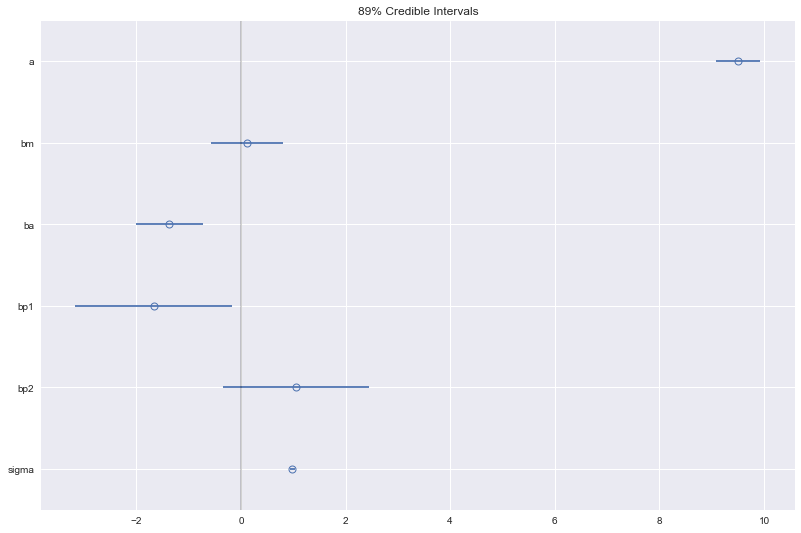

In [68]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
data = pm.summary(trace_5m4, varnames=["a", "bm", "ba", "bp1", "bp2", "sigma"], alpha=0.11)
ax.errorbar(data["mean"], data.index, fmt="o", xerr=data["hpd_94.5"] - data["hpd_5.5"], 
            mew=1, mfc="None")
ax.vlines(0, ymin=-1, ymax=6, alpha=0.2);
ax.set_ylim(-0.5, 5.5)
ax.invert_yaxis()
ax.set_title("89% Credible Intervals");

#### 5M5.

I'm assuming we have average calories gained by eating outside (co) and average calories burned through exercise (ce) and we're fitting a model to the obesity rate per region pulled from $\mathcal{N}(\mu, \sigma)$

If we fit $\mu_i = \alpha + \beta_g g_i + \beta_{co} co_i + \beta_{ce} ce_i$ There are a few possibilities for the coefficients.

1. $\beta_g$ still has an effect on our predictions - this implies that our model is incorrect.
2. Either $\beta_{co}$ or $\beta_{ce}$ covers 0, this implies that our model is correct and the significant coefficient is consequence of the higher gas prices.
3. Both $\beta_{co}$ and $\beta_{ce}$ are significant - this implies that both phenomena occur and the significance can give you an estimate of how much each one contribues.

These are all contingent on our model being correct.

### Hard

In [69]:
foxes = pd.read_csv("data/foxes.csv", delimiter=";")
foxes.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


In [70]:
foxes_s = (foxes
           .assign(weight_s=lambda df: (df["weight"] - df["weight"].mean())/df["weight"].std())
           .assign(area_s=lambda df: (df["area"] - df["area"].mean())/df["area"].std())
           .assign(groupsize_s=lambda df: (df["groupsize"] - df["groupsize"].mean())/df["groupsize"].std())
           .assign(avgfood_s=lambda df: (df["avgfood"] - df["avgfood"].mean())/df["avgfood"].std()))

#### 5H1.

In [71]:
with pm.Model() as m_5h1a:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    a = pm.Normal("a", mu=0, sd=1)
    ba = pm.Normal("ba", mu=0, sd=1)
    mu = pm.Deterministic("mu", a +\
                                ba*foxes_s["area_s"])
    weight = pm.Normal("weight", mu=mu, sd=sigma, observed=foxes_s["weight_s"])
    trace_5h1a = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m_5h1b:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    a = pm.Normal("a", mu=0, sd=1)
    bg = pm.Normal("bg", mu=0, sd=1)
    mu = pm.Deterministic("mu", a +\
                                bg*foxes_s["groupsize_s"])
    weight = pm.Normal("weight", mu=mu, sd=sigma, observed=foxes_s["weight_s"])
    trace_5h1b = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ba, a, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 782.01draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bg, a, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 782.64draws/s] 


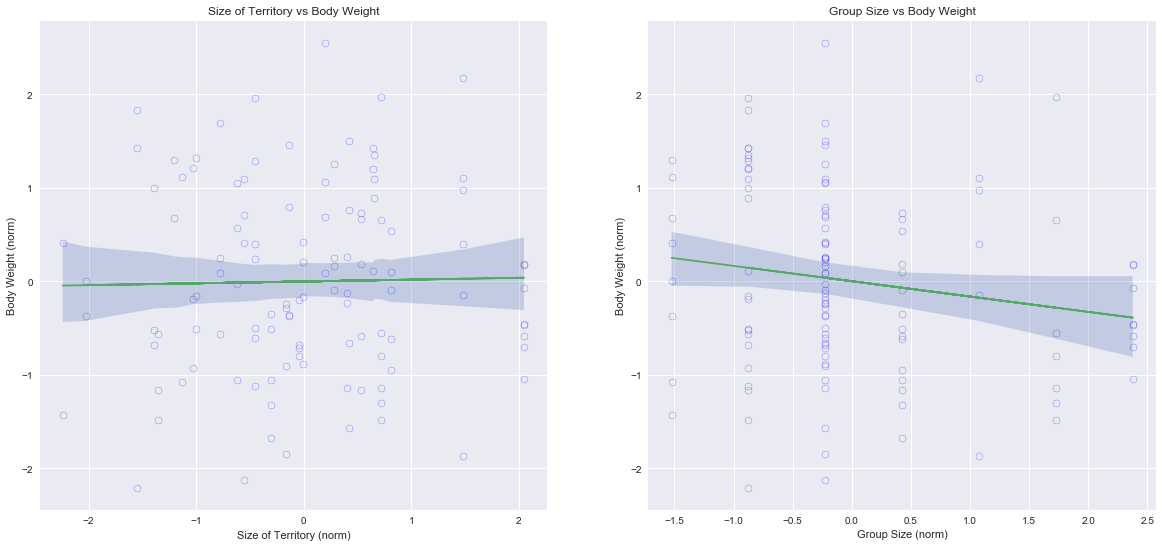

In [72]:
amu_mean = trace_5h1a["mu"].mean(0)
amu_hpdi = pm.hpd(trace_5h1a["mu"])

bmu_mean = trace_5h1b["mu"].mean(0)
bmu_hpdi = pm.hpd(trace_5h1b["mu"])

f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(20, 9)
ax1.plot(foxes_s["area_s"], foxes_s["weight_s"], "o", mew=0.2, mec="b", mfc="None")
ax1.plot(foxes_s["area_s"], amu_mean)
idx = np.argsort(foxes_s["area_s"])
ax1.fill_between(foxes_s["area_s"][idx], amu_hpdi[:,0][idx], amu_hpdi[:,1][idx], alpha=0.25)
ax1.set_title("Size of Territory vs Body Weight")
ax1.set_xlabel("Size of Territory (norm)")
ax1.set_ylabel("Body Weight (norm)")

ax2.plot(foxes_s["groupsize_s"], foxes_s["weight_s"], "o", mew=0.2, mec="b", mfc="None")
ax2.plot(foxes_s["groupsize_s"], bmu_mean)
idx = np.argsort(foxes_s["groupsize_s"])
ax2.fill_between(foxes_s["groupsize_s"][idx], bmu_hpdi[:,0][idx], bmu_hpdi[:,1][idx], alpha=0.25)
ax2.set_title("Group Size vs Body Weight")
ax2.set_xlabel("Group Size (norm)")
ax2.set_ylabel("Body Weight (norm)");

From these bivariate regressions, neither variable is important for predicting fox body weight.

#### 5H2.

In [73]:
with pm.Model() as m_5h2:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    a = pm.Normal("a", mu=0, sd=1)
    ba = pm.Normal("ba", mu=0, sd=1)
    bg = pm.Normal("bg", mu=0, sd=1)
    mu = pm.Deterministic("mu", a +\
                                ba*foxes_s["area_s"] +\
                                bg*foxes_s["groupsize_s"])
    weight = pm.Normal("weight", mu=mu, sd=sigma, observed=foxes_s["weight_s"])
    trace_5h2 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bg, ba, a, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 716.01draws/s]


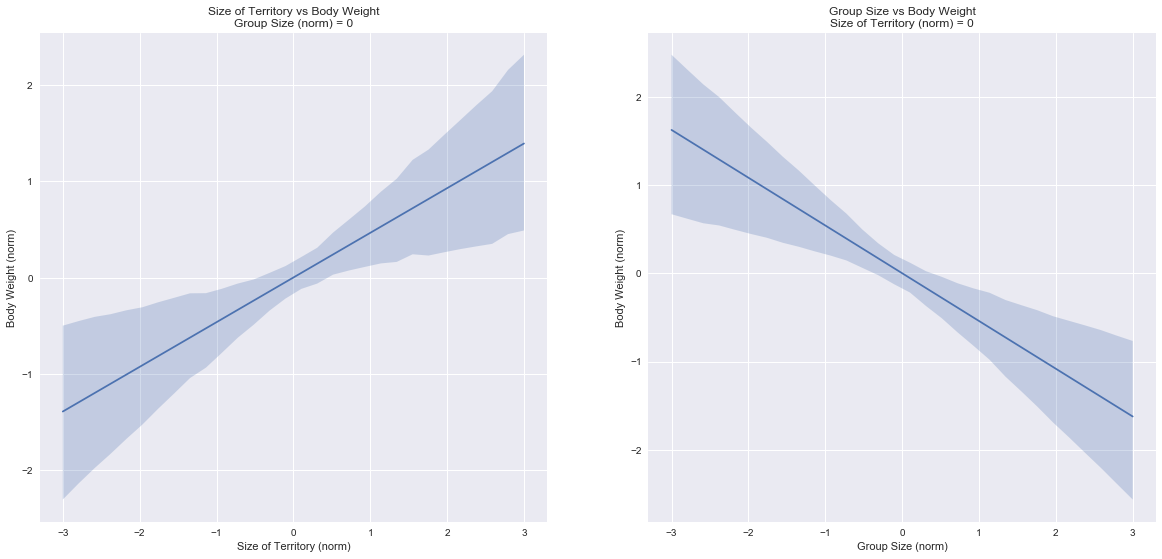

In [74]:
r_seq = np.linspace(-3, 3, 30)

amu = trace_5h2["a"].reshape(-1, 1) +\
      (trace_5h2["ba"].reshape(-1, 1) * r_seq)
amu_mean = amu.mean(axis=0)
amu_hpdi = pm.hpd(amu)

gmu = trace_5h2["a"].reshape(-1, 1) +\
      (trace_5h2["bg"].reshape(-1, 1) * r_seq)
gmu_mean = gmu.mean(axis=0)
gmu_hpdi = pm.hpd(gmu)

f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(20, 9)
ax1.plot(r_seq, amu_mean)
ax1.fill_between(r_seq, amu_hpdi[:,0], amu_hpdi[:,1], alpha=0.25)
ax1.set_title("Size of Territory vs Body Weight\n"
              "Group Size (norm) = 0")
ax1.set_xlabel("Size of Territory (norm)")
ax1.set_ylabel("Body Weight (norm)")

ax2.plot(r_seq, gmu_mean)
ax2.fill_between(r_seq, gmu_hpdi[:,0], gmu_hpdi[:,1], alpha=0.25)
ax2.set_title("Group Size vs Body Weight\n"
              "Size of Territory (norm) = 0")
ax2.set_xlabel("Group Size (norm)")
ax2.set_ylabel("Body Weight (norm)");

From this multivariate regression, it looks like both variables are important, this is possibly because both territory size and group size are positively correlated but while territory size is positively correlated with fox body weight, group size is negatively correlated. This is an example of a masked relationship.

This effect is hidden unless we control for either territory size or group size.

#### 5H3.

In [75]:
with pm.Model() as m_5h3a:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    a = pm.Normal("a", mu=0, sd=1)
    bf = pm.Normal("bf", mu=0, sd=1)
    bg = pm.Normal("bg", mu=0, sd=1)
    mu = pm.Deterministic("mu", a +\
                                bf*foxes_s["avgfood_s"] +\
                                bg*foxes_s["groupsize_s"])
    weight = pm.Normal("weight", mu=mu, sd=sigma, observed=foxes_s["weight_s"])
    trace_5h3a = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m_5h3b:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    a = pm.Normal("a", mu=0, sd=1)
    bf = pm.Normal("bf", mu=0, sd=1)
    bg = pm.Normal("bg", mu=0, sd=1)
    ba = pm.Normal("ba", mu=0, sd=1)
    mu = pm.Deterministic("mu", a +\
                                bf*foxes_s["avgfood_s"] +\
                                bg*foxes_s["groupsize_s"] +\
                                ba*foxes_s["area_s"])
    weight = pm.Normal("weight", mu=mu, sd=sigma, observed=foxes_s["weight_s"])
    trace_5h3b = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bg, bf, a, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:09<00:00, 421.56draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ba, bg, bf, a, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:07<00:00, 500.15draws/s]


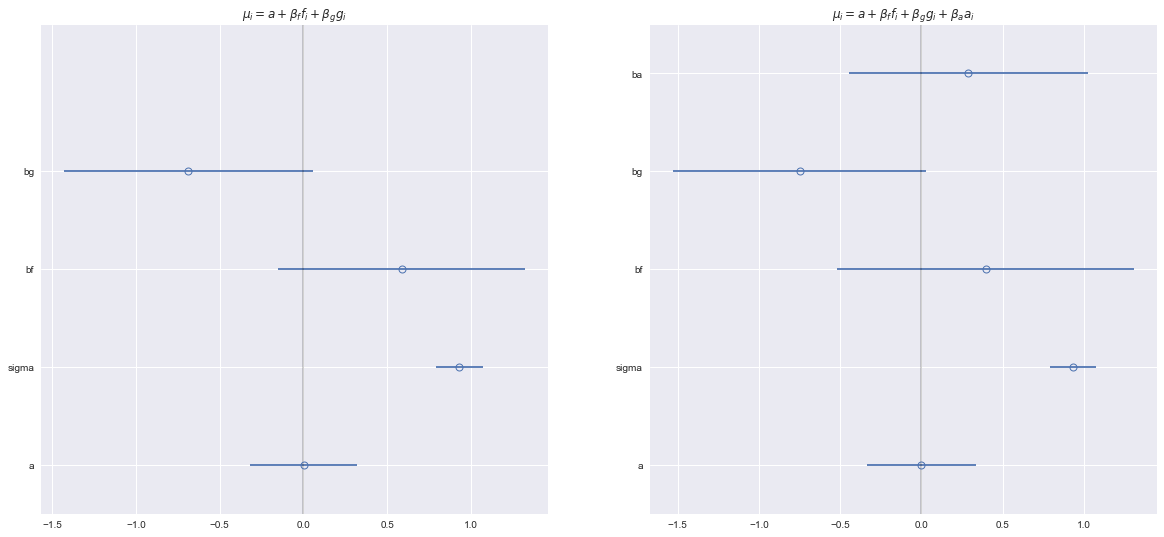

In [76]:
asumm = pm.summary(trace_5h3a, varnames=["a", "sigma", "bf", "bg"])
bsumm = pm.summary(trace_5h3b, varnames=["a", "sigma", "bf", "bg", "ba"])

f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(20, 9)

ax1.errorbar(asumm["mean"], asumm.index, fmt="o", xerr=asumm["hpd_97.5"] - asumm["hpd_2.5"], 
             mew=1, mfc="None")
ax1.vlines(0, ymin=-1, ymax=5, alpha=0.2);
ax1.set_ylim(-0.5, 4.5)

ax2.errorbar(bsumm["mean"], bsumm.index, fmt="o", xerr=bsumm["hpd_97.5"] - bsumm["hpd_2.5"], 
             mew=1, mfc="None")
ax2.vlines(0, ymin=-1, ymax=5, alpha=0.2)
ax2.set_ylim(-0.5, 4.5);

ax1.set_title("$\mu_i = a + \\beta_f f_i + \\beta_g g_i $")
ax2.set_title("$\mu_i = a + \\beta_f f_i + \\beta_g g_i + \\beta_a a_i $");

(a) I would guess that `avgfood` is a better indicator of body weight since it directly affects it, `area` probably affects body weight via it's effect on `avgfood`

(b) The model can't disentangle the effects of `avgfood` and `area` on body weight and thus tries to give each feature equal weight.